<a href="https://colab.research.google.com/github/AayanHidol/NNZH-by-Andrej-Karpathy/blob/main/Building_makemore_Part_5_Building_a_WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt

--2025-07-17 17:52:48--  https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-07-17 17:52:48 (6.01 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [17]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [18]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [19]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [62]:
# Build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [63]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [126]:
# ----------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ----------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # Buffers (training with a running 'momentum updatae')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # Calculate the forwars pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True)   # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    # Update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# ----------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
# ----------------------------------------------------------------

class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# ----------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# ----------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # Get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

# ----------------------------------------------------------------




In [127]:
torch.manual_seed(42); # seed rng for reproducibility

In [128]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 128 # the. number of neurons in the hidden layer of the MLP

model =  Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

72617


In [129]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  1,  1, 19,  8,  9, 11],
        [ 0,  0,  0,  0,  0,  0, 23, 25],
        [ 0,  0,  0,  0, 18,  9, 12,  5],
        [ 0,  0,  0,  0,  0, 14,  1,  5]])

In [130]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [131]:
e = torch.randn(32, 4, 68)
emean = e.mean((0,1), keepdim=True) # 1, 1, 68
evar = e.var((0,1), keepdim=True) # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [132]:
emean.shape

torch.Size([1, 1, 68])

In [133]:
logits.shape

torch.Size([4, 27])

In [134]:
model.layers[0].out.shape # Output of Embedding layer

torch.Size([4, 8, 10])

In [135]:
model.layers[1].out.shape # Output of Flatten layer

torch.Size([4, 4, 20])

In [136]:
model.layers[2].out.shape # Output of Linear layer

torch.Size([4, 4, 128])

In [137]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [138]:
# (1 2) (3 4) (5 6) (7 8)

In [139]:
list(range(10)) [1::2]

[1, 3, 5, 7, 9]

In [140]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [141]:
e = torch.randn(4, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [142]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [143]:
# Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # MiniBatch Construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # Forward Pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # Backward Pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step lr decay
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  #break

      0/ 200000: 3.3013
  10000/ 200000: 2.3104
  20000/ 200000: 2.2830
  30000/ 200000: 2.3839
  40000/ 200000: 1.9035
  50000/ 200000: 2.0606
  60000/ 200000: 1.9936
  70000/ 200000: 2.1230
  80000/ 200000: 1.9147
  90000/ 200000: 2.2183
 100000/ 200000: 2.6973
 110000/ 200000: 1.7425
 120000/ 200000: 1.8100
 130000/ 200000: 1.7629
 140000/ 200000: 1.8080
 150000/ 200000: 2.0571
 160000/ 200000: 1.6516
 170000/ 200000: 1.6038
 180000/ 200000: 1.9166
 190000/ 200000: 1.6670


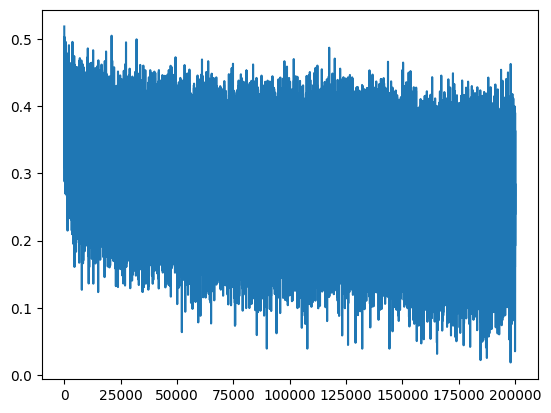

In [148]:
plt.plot(lossi)

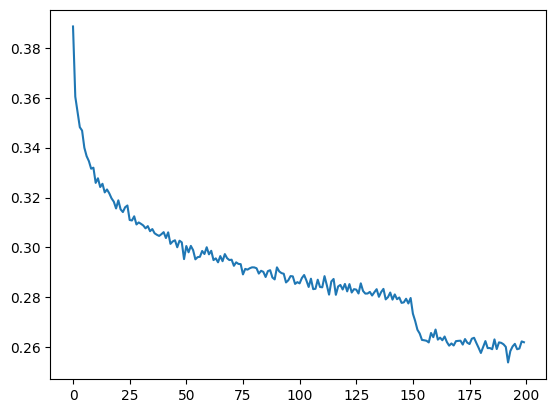

In [149]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [150]:
torch.arange(10).view(-1,5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [151]:
# Put layers into eval mode (needed for BatchNorm especially)
for layer in model.layers:
  layer.training = False

In [152]:
# Evaluate the loss
@torch.no_grad() # this decorater disables gradient tracking inside pytorch
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val'  : (Xdev, Ydev),
      'test' : (Xte, Yte),
  } [split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.797640085220337
val 1.9930140972137451


### performance log
* original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
* context: 3 -> 8 (22K params): train 1.918, val 2.027
* flat -> hierarchical (22K params): train 1.941, val 2.029
* fix bug in batchnorm: train 1.912, val 2.022
* scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993

In [153]:
# Sample from the model

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ....
  while True:
    # Forward Pass through the NN
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)

    # Sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()

    # Shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)

    # If we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # Decode and print the generated word

mo.
carls.
isami.
ziciah.
neyla.
brixtin.
zaliza.
yanon.
kienne.
cadina.
ellie.
anelee.
brooke.
liliane.
mariah.
akaira.
palic.
traiden.
zelien.
darwin.


## Next time

Why convolutions? Brief preview/ hint

In [154]:
for x, y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .


In [155]:
# Forward a single eg
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [156]:
# Forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [157]:
# Convolution is a 'for loop'
# allows us to forward Linear layers efficiently over space